## Formula 1
Business Problem: What factors/features are needed to predict race outcome

1. Import required libraries

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols
from scipy.stats import norm, probplot
from sklearn.preprocessing import StandardScaler


Get Data from the erghast F1 API
</br> Contains data from all the races since 1950

2. Import the datasets from the erghast API for the prediction

In [94]:
db_dir = os.getcwd()
pit_stops = pd.read_csv(db_dir + r'/data/pit_stops.csv')
races = pd.read_csv(db_dir + r'/data/races.csv')
drivers = pd.read_csv(db_dir + r'/data/drivers.csv')
results = pd.read_csv(db_dir + r'/data/results.csv')
driver_standings = pd.read_csv(db_dir + r'/data/driver_standings.csv')
circuits = pd.read_csv(db_dir + r'/data/circuits.csv')
qualifying = pd.read_csv(db_dir + r'/data/qualifying.csv')
lap_times = pd.read_csv(db_dir + r'/data/lap_times.csv')
lap_times = lap_times.rename(columns={
    'time': 'lapTime',
    'position': 'lapPosition'})

merged_df = pd.merge(races, pit_stops, on='raceId', how='inner')
df = pd.merge(merged_df, drivers, on='driverId', how='inner')
df = df.drop(columns=['url_x','url_y','number'])

# distinct_raceyear_df = df.drop_duplicates(subset='year').sort_values(by='year', ascending=False)
df_new_merged = pd.merge(df, results, on=['driverId','raceId'], how='inner')
df_new_merged1 = pd.merge(df_new_merged, driver_standings, on=['driverId','raceId'], how='inner')
df_new_merged = pd.merge(df_new_merged, circuits, on=['circuitId'], how='inner')
# df_new_merged = pd.merge(df_new_merged, qualifying, on=['driverId','raceId'], how='inner')
# df_new_merged = pd.merge(df_new_merged, lap_times, on=['driverId','raceId'], how='inner')

condition1 = df_new_merged['year'] >= 2000
condition2 = df_new_merged['year'] <= 2023
df_new_merged1 = df_new_merged[condition1 & condition2 ] 
print(df_new_merged1.columns)
df_new_merged1.to_csv('all.csv')
def convert_new_time_to_seconds_v4(time_str):
    if time_str == '\\N':
        return np.nan
    try:
        # Split by colon and reverse the list to start with seconds and go backwards to minutes, hours, etc.
        time_parts = list(map(float, time_str.split(':')))[::-1]
        # Convert parts to seconds: seconds, minutes to seconds, hours to seconds
        total_seconds = sum(time_part * (60 ** index) for index, time_part in enumerate(time_parts))
        return total_seconds
    except ValueError:
        return np.nan

# Apply the function to the 'new_time' column
df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)
# df_new_merged1[df_new_merged1['raceId']== 948].sort_values(by=['raceId', 'positionOrder'])
df_cleaned = df_new_merged1[['raceId','year','round','circuitRef','circuit_type','driverId','grid','position','positionOrder','time','new_time_seconds']]
df_cleaned = df_cleaned.drop_duplicates()
# df_cleaned['cumulative_time_seconds'] = df_cleaned.groupby(['raceId', 'positionOrder'])['new_time_seconds'].transform(lambda x: x.cumsum())
df_cleaned.sort_values(by=['raceId', 'positionOrder'], inplace=True)
df_cleaned['cumulative_time_seconds'] = df_cleaned.groupby('raceId')['new_time_seconds'].cumsum()
df_cleaned = df_cleaned[['raceId','year','circuitRef','circuit_type','driverId','grid','cumulative_time_seconds']]

df_cleaned[df_cleaned['raceId']== 950].sort_values(by=['raceId','grid'])

# df_cleaned = df_cleaned[df_cleaned['circuitRef']== 'monaco']

#Drop retired racers
df_cleaned = df_cleaned.dropna()

Index(['raceId', 'year', 'round', 'circuitId', 'name_x', 'date', 'time_x',
       'fp1_date', 'fp1_time', 'fp2_date', 'fp2_time', 'fp3_date', 'fp3_time',
       'quali_date', 'quali_time', 'sprint_date', 'sprint_time', 'driverId',
       'stop', 'lap', 'time_y', 'duration', 'milliseconds_x', 'driverRef',
       'code', 'forename', 'surname', 'dob', 'nationality', 'resultId',
       'constructorId', 'number', 'grid', 'position', 'positionText',
       'positionOrder', 'points', 'laps', 'time', 'milliseconds_y',
       'fastestLap', 'rank', 'fastestLapTime', 'fastestLapSpeed', 'statusId',
       'circuitRef', 'name_y', 'location', 'country', 'lat', 'lng', 'alt',
       'url', 'circuit_type'],
      dtype='object')


/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_53368/2055408379.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_merged1['new_time_seconds'] = df_new_merged1['time'].replace('\+', '', regex=True).apply(convert_new_time_to_seconds_v4)


R-Squared: 0.03139078681270291
                               OLS Regression Results                              
Dep. Variable:     cumulative_time_seconds   R-squared:                       0.031
Model:                                 OLS   Adj. R-squared:                  0.030
Method:                      Least Squares   F-statistic:                     29.74
Date:                     Mon, 22 Jul 2024   Prob (F-statistic):           6.41e-19
Time:                             20:20:18   Log-Likelihood:                -23726.
No. Observations:                     2790   AIC:                         4.746e+04
Df Residuals:                         2786   BIC:                         4.748e+04
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

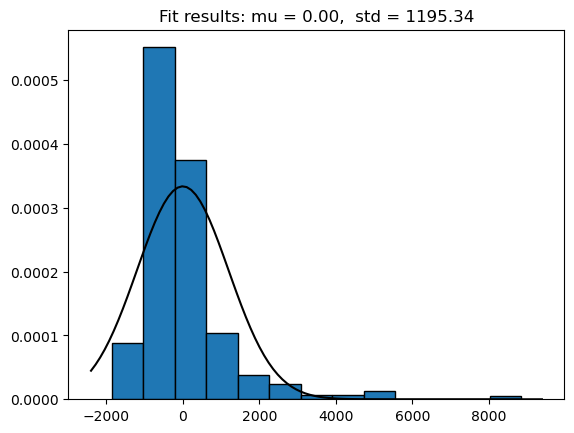

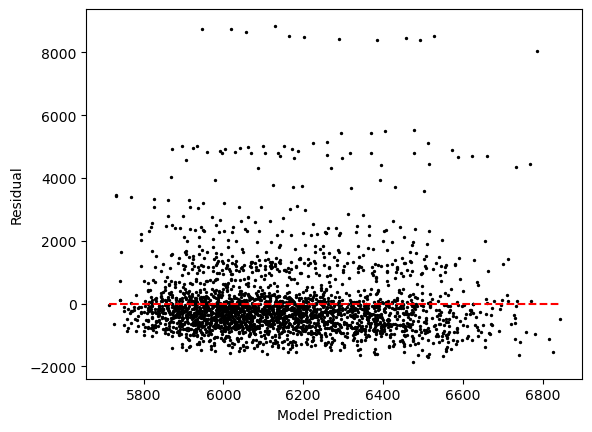

In [95]:
X = df_cleaned[['raceId','year','driverId','grid']].values
y = df_cleaned['cumulative_time_seconds'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.95,random_state=0)

'''
Fitting data to a regression model requires two arguments, the training X
values (independent variables) and the training y values (dependent variables.
In general, most fit functions for models follow this format.
'''
reg = LinearRegression().fit(X_train, y_train)
print("R-Squared:", reg.score(X_train, y_train))

from statsmodels.formula.api import ols

model = ols('cumulative_time_seconds ~ raceId+year+grid',df_cleaned).fit()
print(model.summary())

#Test for normality
predicted_y = reg.predict(X_train)
residuals = y_train - predicted_y

from scipy.stats import norm
mean, std = norm.fit(residuals)
plt.hist(residuals, bins=13, edgecolor='black', density=True)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)
plt.show()

#Test for heteroskacticity
#Residuals calculated by definition above.
predicted_y = reg.predict(X_train)
#Note we can perform element-wise subtraction between arrays like so
residuals = y_train - predicted_y
import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')
plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

#### Exploration of the data
3. Does the data have NULL Values?
<br/> From our analysis below, there are no null values
<br/>No need to apply MICE

In [16]:
df_new_merged1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5978 entries, 481 to 10988
Data columns (total 45 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   raceId           5978 non-null   int64  
 1   year             5978 non-null   int64  
 2   round            5978 non-null   int64  
 3   circuitId        5978 non-null   int64  
 4   name             5978 non-null   object 
 5   date             5978 non-null   object 
 6   time_x           5978 non-null   object 
 7   fp1_date         5978 non-null   object 
 8   fp1_time         5978 non-null   object 
 9   fp2_date         5978 non-null   object 
 10  fp2_time         5978 non-null   object 
 11  fp3_date         5978 non-null   object 
 12  fp3_time         5978 non-null   object 
 13  quali_date       5978 non-null   object 
 14  quali_time       5978 non-null   object 
 15  sprint_date      5978 non-null   object 
 16  sprint_time      5978 non-null   object 
 17  driverId        

4. Create a prediction Value
<br/> In this case we are going to be using the column position_x (Final Race Position) == 1 as the race winner

In [17]:
import numpy as np
df_new_merged1['RaceWinner'] = np.where(df_new_merged1['position'] == '1', 1, 0)
df_new_merged1[df_new_merged1['RaceWinner']==1].head()
relevant_columns = ['raceId', 'year', 'round', 'circuitId', 'driverId', 'grid', 'positionOrder','position', 'fastestLapTime', 'points', 'RaceWinner','rank','laps']
# relevant_columns = ['raceId', 'grid', 'positionOrder', 'fastestLapTime', 'points','RaceWinner']
new_df = df_new_merged1[relevant_columns]
def time_to_seconds(time_str):
    # Check if the input is a string and contains the expected ':' character
    if pd.isna(time_str) or ':' not in time_str:
        return None  # Return None for missing or malformed data
    
    # Try to split the time string and convert to seconds
    try:
        minutes, seconds = time_str.split(':')
        return int(minutes) * 60 + float(seconds)
    except ValueError:
        return None

# Apply the function to the column
new_df['fastestLapTime_seconds'] = new_df['fastestLapTime'].apply(time_to_seconds)
new_df = new_df.drop(columns=['fastestLapTime'])
new_df.head()

/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_38562/3492287986.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_merged1['RaceWinner'] = np.where(df_new_merged1['position'] == '1', 1, 0)
/var/folders/mr/l3x9p9wd385gcyns864s9f2w0000gn/T/ipykernel_38562/3492287986.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['fastestLapTime_seconds'] = new_df['fastestLapTime'].apply(time_to_seconds)


,raceId,year,round,circuitId,driverId,grid,positionOrder,position,points,RaceWinner,rank,laps,fastestLapTime_seconds
481,948,2016,1,1,4,11,21,\N,0.0,0,11,16,92.553
482,950,2016,3,17,4,11,12,12,0.0,0,19,56,102.226
483,950,2016,3,17,4,11,12,12,0.0,0,19,56,102.226
484,951,2016,4,71,4,14,6,6,8.0,0,5,52,100.347
485,952,2016,5,4,4,10,19,\N,0.0,0,13,45,89.750


5. Treating for NaN:
<br/> After converting fastestLapTime from MM:SS to SS we noticed that some of the volumes is NaN.
<br/> To solve for this, we converted we turn NaN into 0
<br/> When researching more why this may happen, driver may have not finished the race. This meaning 0 means they did not finish the race.

In [23]:
new_df['fastestLapTime_seconds'] = new_df['fastestLapTime_seconds'].fillna(0)
new_df.isna().any()
df_cleaned = new_df
# df_cleaned = new_df.dropna()
# df_cleaned.isna().any()

5. Which features have significance to predict race outcome?
<br/> Linear Regression - The grid,positionOrder,points_y,wins look to have the lowest P value


In [29]:
X = df_cleaned[['raceId', 'year', 'round', 'circuitId', 'driverId', 'grid','positionOrder', 'points', 'RaceWinner','fastestLapTime_seconds']].values
y = df_cleaned['RaceWinner'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.95,random_state=0)

'''
Fitting data to a regression model requires two arguments, the training X
values (independent variables) and the training y values (dependent variables.
In general, most fit functions for models follow this format.
'''
reg = LinearRegression().fit(X_train, y_train)
print("R-Squared:", reg.score(X_train, y_train))

from statsmodels.formula.api import ols

model = ols('RaceWinner ~ raceId+year+round+circuitId+driverId+grid+positionOrder+points+fastestLapTime_seconds+points+rank+laps',new_df).fit()
print(model.summary())

R-Squared: 1.0
                            OLS Regression Results                            
Dep. Variable:             RaceWinner   R-squared:                       0.545
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     222.6
Date:                Sat, 20 Jul 2024   Prob (F-statistic):               0.00
Time:                        09:51:08   Log-Likelihood:                 2940.6
No. Observations:                5978   AIC:                            -5815.
Df Residuals:                    5945   BIC:                            -5594.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept    

6. Test for heteroskacticity

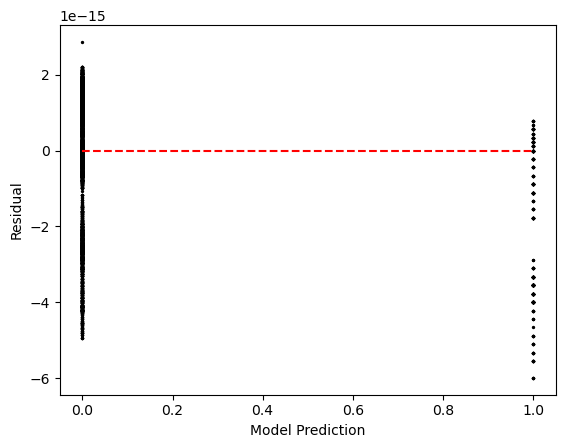

In [9]:
#Residuals calculated by definition above.
predicted_y = reg.predict(X_train)
#Note we can perform element-wise subtraction between arrays like so
residuals = y_train - predicted_y

import matplotlib.pyplot as plt
plt.scatter(predicted_y,residuals,s=2,c='black')

#This line adds the dashed horizontal line
plt.hlines(0,min(predicted_y),max(predicted_y),color='red',linestyles='dashed')

plt.xlabel("Model Prediction")
plt.ylabel("Residual")
plt.show()

6. Test for normality

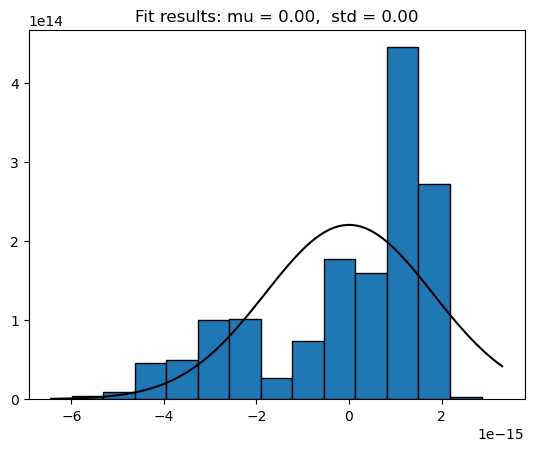

In [10]:
from scipy.stats import norm

# Fit a normal distribution to the data:
mean, std = norm.fit(residuals)

# Plot the histogram.
plt.hist(residuals, bins=13, edgecolor='black', density=True)

# Generate a PDF based on the fitted distribution
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mean, std)
plt.plot(x, p, color='black')
title = "Fit results: mu = %.2f,  std = %.2f" % (mean, std)
plt.title(title)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulating some left-skewed data
data = np.random.exponential(scale=1, size=1000) - 1.5

# Step 1: Adjust data if there are negative or zero values
data_min = data.min()
if data_min <= 0:
    data_adjusted = data + (abs(data_min) + 1)
else:
    data_adjusted = data

# Step 2: Apply log transformation
data_log_transformed = np.log(data_adjusted)

# Step 3: Plotting the transformed data
plt.figure(figsize=(10, 6))
plt.hist(data_log_transformed, bins=30, color='blue', alpha=0.7)
plt.title('Histogram of Log Transformed Data')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Pagan Test to further test the heteroskacticity

In [26]:
#Import the relevant libraries and train the model
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import het_breuschpagan

results = ols('RaceWinner ~ raceId+year+round+circuitId+driverId+grid+positionOrder+fastestLapTime_seconds+points+rank+laps',df_cleaned).fit()
#Perform the Breuch-Pagan Test by running this line
bp = het_breuschpagan(results.resid,results.model.exog)
measures = ('LM Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value')
print(dict(zip(measures,bp)))

{'LM Statistic': 4506.929957615278, 'LM-Test p-value': 0.0, 'F-Statistic': 569.1796155612536, 'F-Test p-value': 0.0}


In [27]:

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
# Predictions on the test set
y_pred_test = reg.predict(X_test)

# Evaluating the model on the test data
r_squared_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_test, y_pred_test)

print("R-Squared on Test Data:", r_squared_test)
print("Mean Squared Error on Test Data:", mse_test)

R-Squared on Test Data: 1.0
Mean Squared Error on Test Data: 3.7079585429789036e-30


In [44]:
condition11 = df_new_merged['year'] == 2024 
condition12 = df_new_merged['round']  == 10
to_predict = df_new_merged[condition11 & condition12]
relevant_columns = ['raceId', 'year', 'round', 'circuitId', 'driverId', 'grid', 'positionOrder', 'points','rank','laps','fastestLapTime']
# relevant_columns = ['raceId', 'grid', 'positionOrder', 'fastestLapTime', 'points','RaceWinner']
to_predict = to_predict[relevant_columns]
to_predict['fastestLapTime_seconds'] = to_predict['fastestLapTime'].apply(time_to_seconds)
to_predict = to_predict.drop(columns=['fastestLapTime'])
to_predict.to_csv('to_predict.csv')

In [45]:
# Add a constant for prediction with statsmodels
features_sm = sm.add_constant(to_predict)

# Prediction using the built model
predict_final_race_outcome = results.predict(features_sm)
predict_final_race_outcome.to_csv('predict.csv')

Chow Test

Purpose:
The Chow test is used to determine whether there are structural breaks or differences between two or more groups in regression analysis. It tests whether the coefficients in two or more regressions on different data sets are equal.

When to Use:

	•	When you want to test if there is a significant difference in regression coefficients between two different groups (e.g., before and after an event, or between different demographic groups).
	•	When you suspect that the relationship between the dependent and independent variables may differ between groups and want to formally test this hypothesis.
    
Wald Test

Purpose:
The Wald test is used to test the significance of individual coefficients or sets of coefficients in a regression model. It tests whether the coefficients of the independent variables are significantly different from zero (or another specified value).

When to Use:

	•	When you want to test the overall significance of one or more coefficients in a regression model.
	•	When you want to test specific hypotheses about the coefficients, such as whether they are equal to each other or to some specified value.
